In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
# import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

print("Imported all libraries")

TensorFlow 1.x selected.
1.15.2
Imported all libraries


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [4]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [6]:
countofActivity=df['activity'].value_counts()
print(countofActivity)

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64


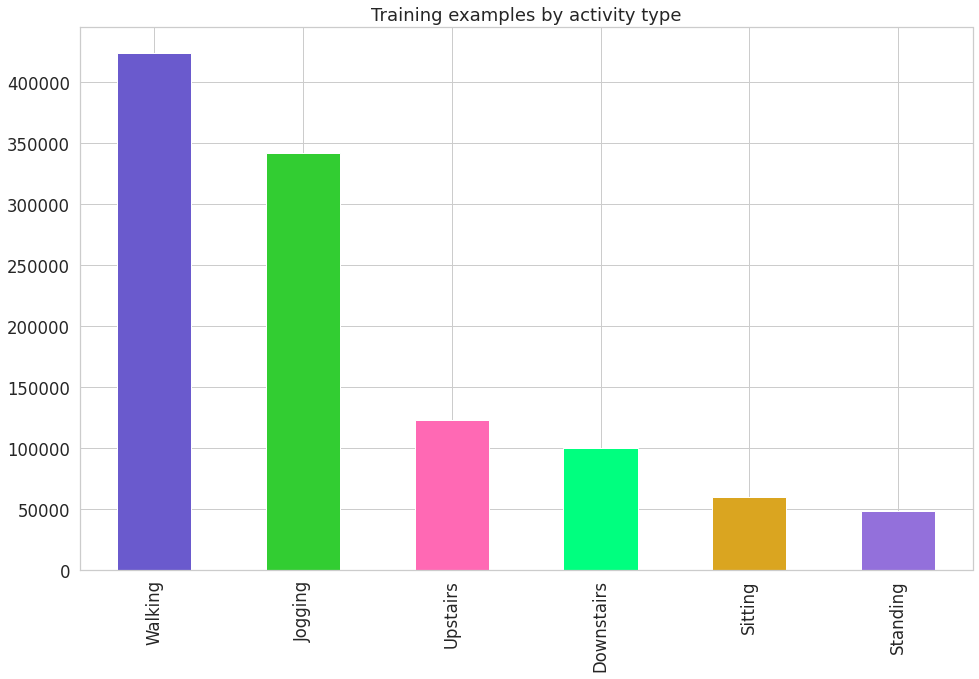

In [7]:
countofActivity.plot(kind='bar', title='Training examples by activity type',figsize=(16,10),color=['slateblue', 'limegreen', 'hotpink', 'springgreen', 'goldenrod','mediumpurple']);

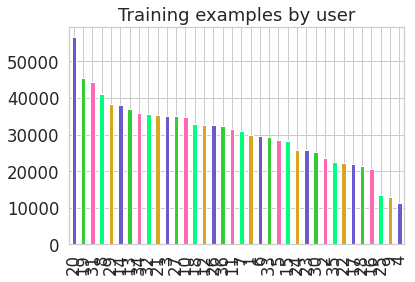

In [8]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user',color=['slateblue', 'limegreen', 'hotpink', 'springgreen', 'goldenrod']);

In [9]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

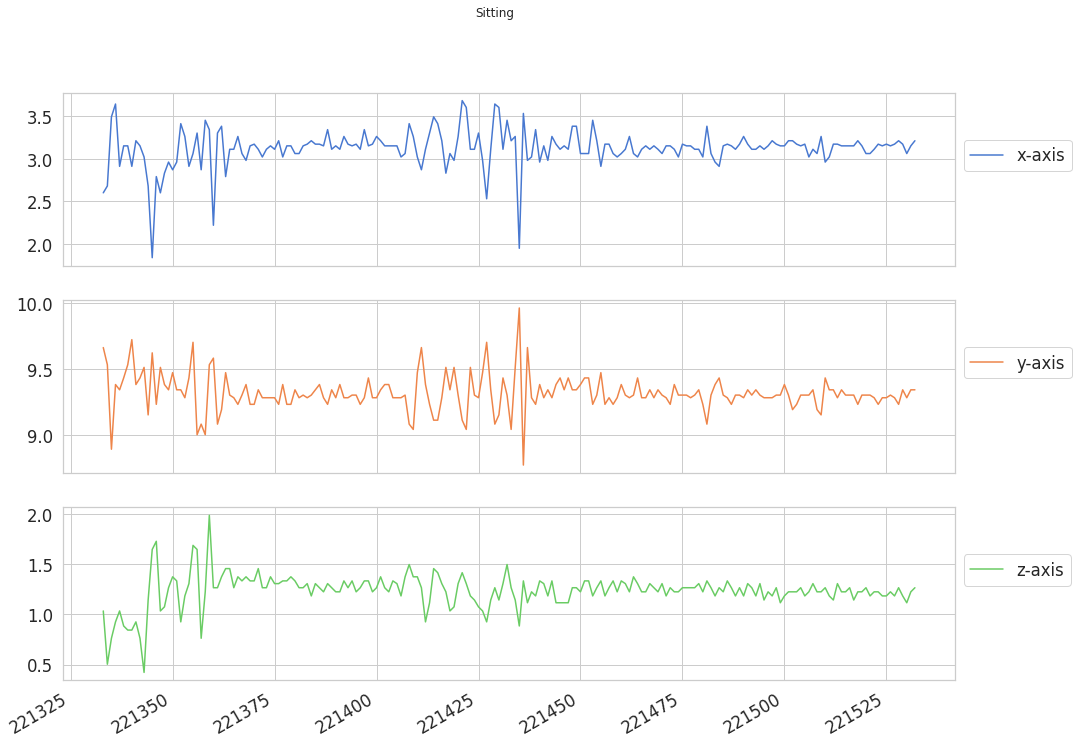

In [10]:
plot_activity("Sitting", df)

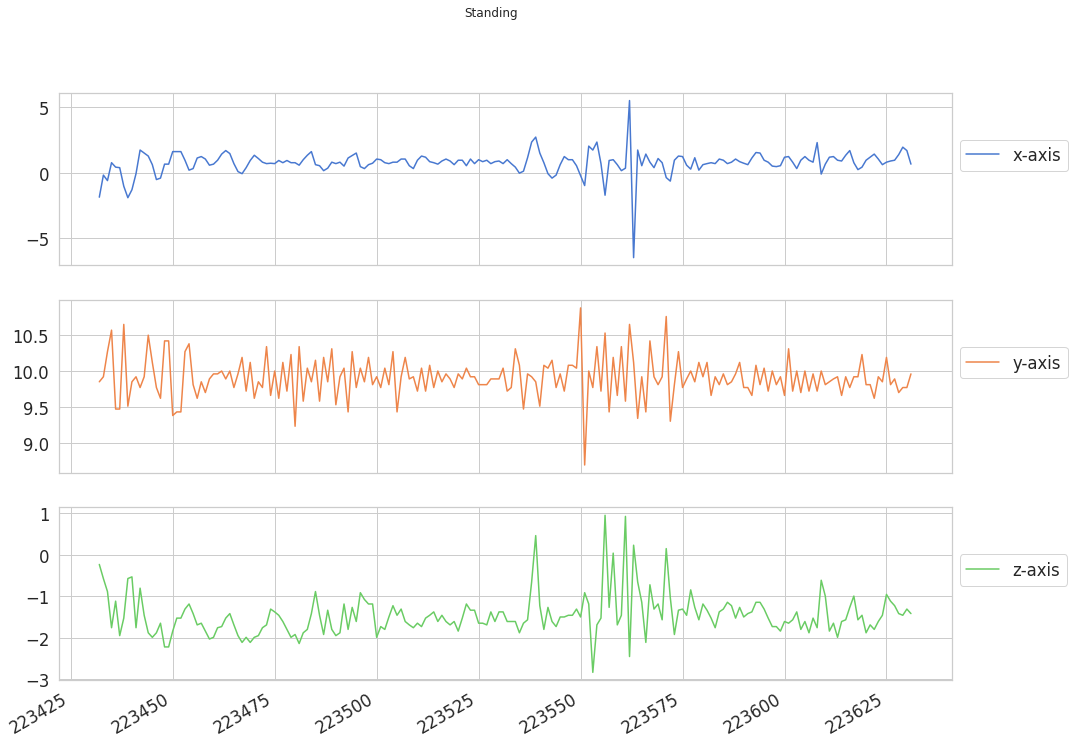

In [11]:
plot_activity("Standing", df)

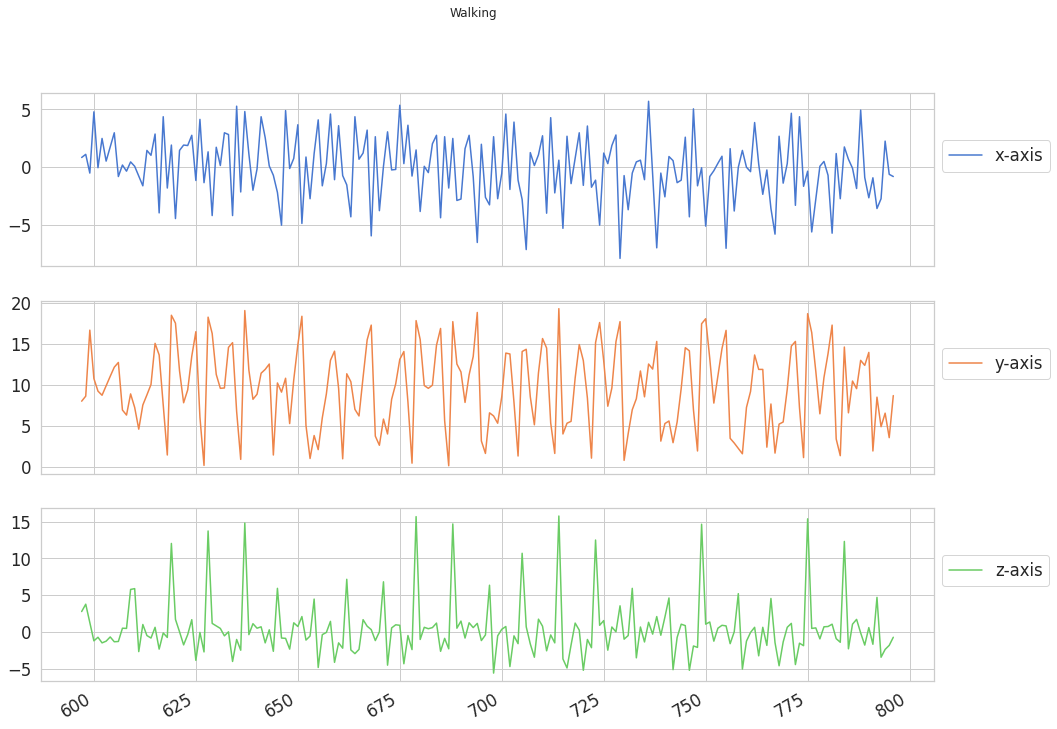

In [12]:
plot_activity("Walking", df)

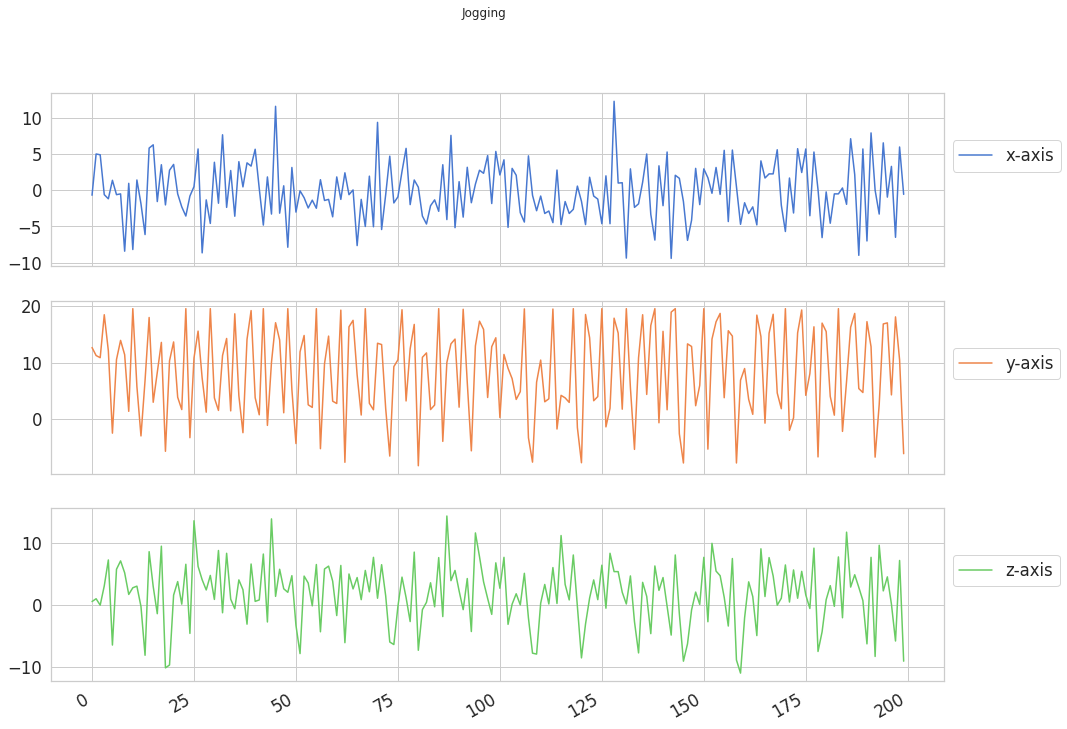

In [13]:
plot_activity("Jogging", df)

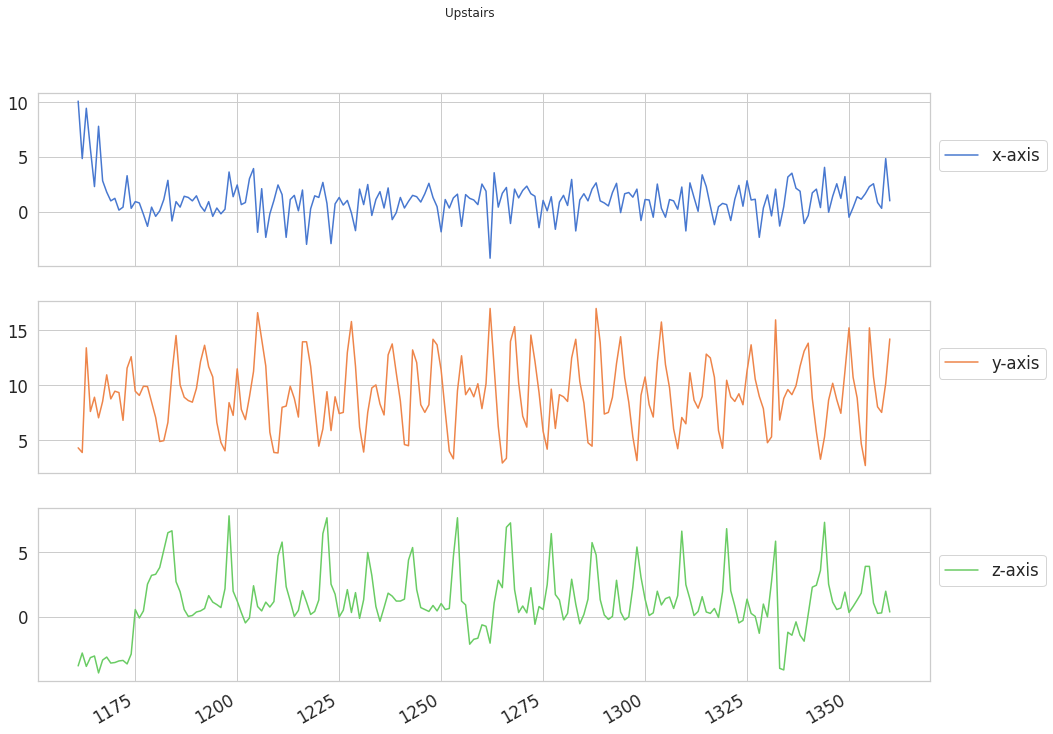

In [14]:
plot_activity("Upstairs", df)

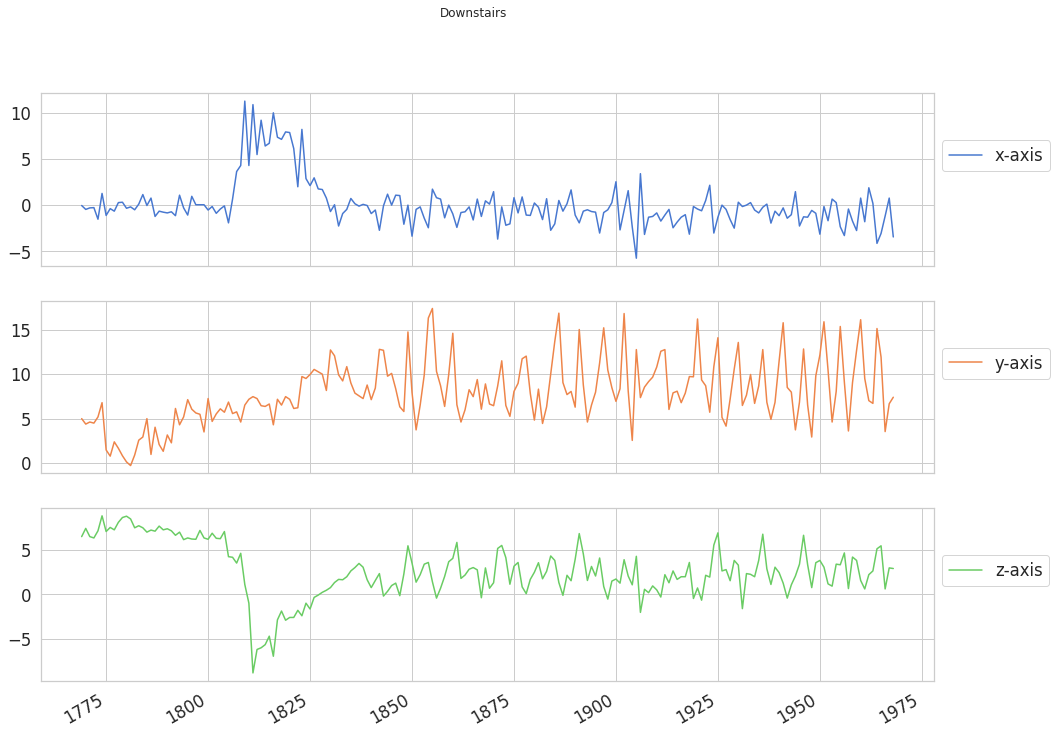

In [15]:
plot_activity("Downstairs", df)

In [16]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [17]:
np.array(segments).shape

(54901, 3, 200)

In [18]:
reshaped_segment = np.asarray(segments)
reshaped_segments = reshaped_segment.astype(float).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32) ## One Hot Encoding of labels

In [19]:
reshaped_segments.shape

(54901, 200, 3)

In [20]:
print(labels)
print(labels.shape)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(54901, 6)


In [21]:
labels[0]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [23]:
len(X_train)

43920

In [24]:
len(X_test)

10981

In [25]:
N_CLASSES = 6
N_HIDDEN_NEURONS = 64

def createBidirLSTM(X, SEGMENT_TIME_SIZE, N_HIDDEN_NEURONS):

    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, 2*N_HIDDEN_NEURONS])),
        'output': tf.Variable(tf.random_normal([2*N_HIDDEN_NEURONS, N_CLASSES]))
    }

    b = {
        'hidden': tf.Variable(tf.random_normal([2*N_HIDDEN_NEURONS], mean=1.0)),
        'output': tf.Variable(tf.Variable(tf.random_normal([N_CLASSES])))
    }

    # Transpose and then reshape to 2D of size (BATCH_SIZE * SEGMENT_TIME_SIZE, N_FEATURES)
    X = tf.unstack(X, SEGMENT_TIME_SIZE, 1)

    # Stack two LSTM cells on top of each other
    lstm_fw_cell_1 = tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_NEURONS, forget_bias=1.0)
    lstm_fw_cell_2 = tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_NEURONS, forget_bias=1.0)
    lstm_bw_cell_1 = tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_NEURONS, forget_bias=1.0)
    lstm_bw_cell_2 = tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_NEURONS, forget_bias=1.0)

    outputs, _, _ = tf.contrib.rnn.stack_bidirectional_rnn([lstm_fw_cell_1, lstm_fw_cell_2], [lstm_bw_cell_1, lstm_bw_cell_2], X, dtype=tf.float32)

    # Get output for the last time step from a "many to one" architecture
    last_output = outputs[-1]
    return tf.matmul(last_output, W['output'] + b['output'], name="lstm_model")

In [26]:
# from tensorflow.python.framework import ops
# ops.reset_default_graph()

from tensorflow.keras.models import Sequential

tf.compat.v1.get_default_graph()

X = tf.compat.v1.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.compat.v1.placeholder(tf.float32, [None, N_CLASSES])

In [27]:
# import tensorflow as tf

pred_Y = createBidirLSTM(X, 200,N_HIDDEN_NEURONS)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initi

In [28]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [30]:
N_EPOCHS = 4
BATCH_SIZE = 1024

In [31]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.7215189933776855 loss: 1.9038746356964111

final results: accuracy: 0.8511064648628235 loss: 1.1732982397079468


In [32]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

In [33]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

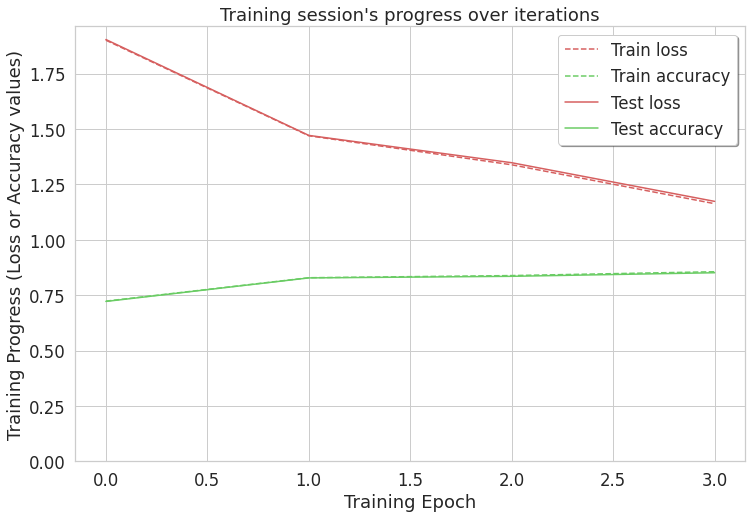

In [34]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [35]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

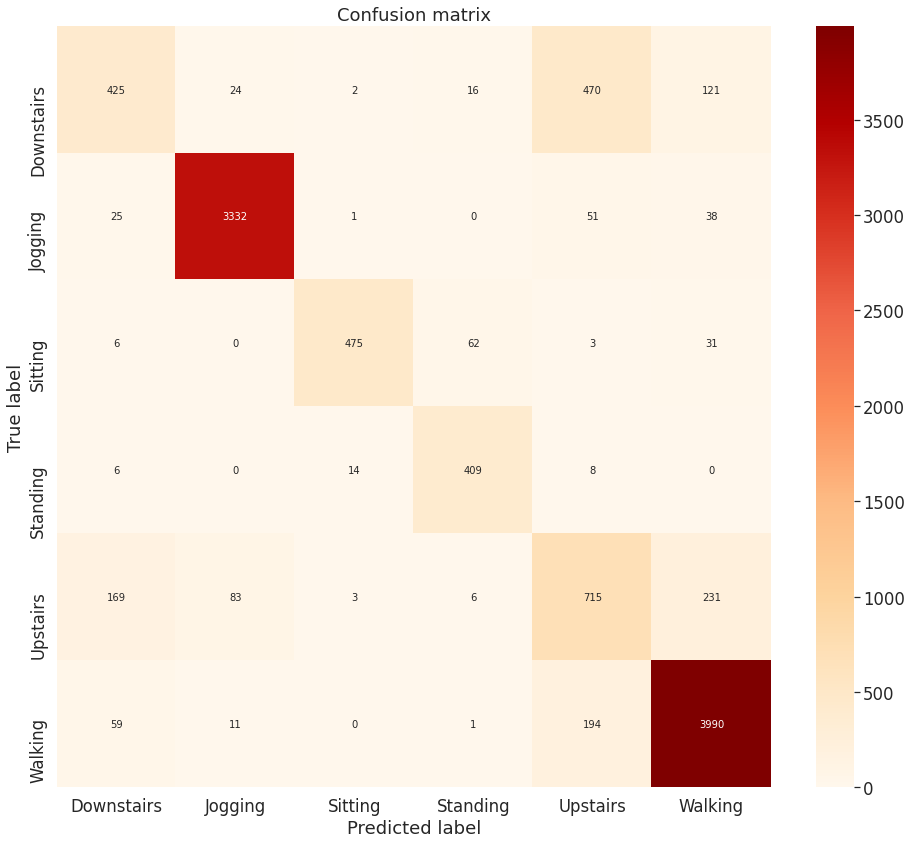

In [36]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="OrRd");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();